<a href="https://colab.research.google.com/github/lorenzkap/lecture/blob/main/lecture4_REINFORCE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Introducing Gymnasium and CartPole


The **Gymnasium** library provides a wide range of pre-built environments designed for benchmarking RL algorithms. This lets us focus on the agent's learning logic.

We'll use a classic Gymnasium environment called **CartPole-v1**.

https://gymnasium.farama.org/environments/classic_control/cart_pole/

*   **Goal:** Balance a vertical pole on top of a cart that moves along a track.
*   **Observation Space (State):** What the agent sees. It's a vector of 4 continuous values:
    1.  Cart Position
    2.  Cart Velocity
    3.  Pole Angle (0 is upright)
    4.  Pole Angular Velocity (how fast it's tipping)
*   **Action Space:** What the agent can do. It's discrete with 2 actions:
    *   0: Push cart Left
    *   1: Push cart Right
*   **Reward:** The agent receives a +1 reward for every time step the pole remains upright within certain angle limits and the cart stays within track boundaries.
*   **Episode Termination:** An episode ends if:
    *   The pole angle exceeds a threshold (pole falls).
    *   The cart position exceeds boundaries (cart goes off track).
    *   A time limit (500 steps for v1) is reached (truncated).
*   **Objective:** Maximize the total reward by keeping the pole balanced for as long as possible (up to 500 steps).



In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt

def train_agent_cartpole(episodes=1000, hidden_size=64, lr=1e-3, gamma=0.99, print_every=50, save_path="best_dqn_agent.pth"):
    env = gym.make('CartPole-v1')
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n

    # Instantiate agent and move to device
    agent = DQNAgent(state_size, action_size, hidden_size, lr, buffer_size=10000, batch_size=64, gamma=gamma, tau=0.005, epsilon_start=1.0, epsilon_end=0.01, epsilon_decay=0.995).to(device)

    episode_rewards = []
    from collections import deque
    recent_rewards = deque(maxlen=print_every)

    best_avg_reward = -float('inf')

    for episode in range(episodes):
        state_np, info = env.reset()
        total_reward = 0
        terminated = False
        truncated = False

        for t in range(env.spec.max_episode_steps):
            action_int = agent.get_action(state_np)

            next_state_np, reward, terminated, truncated, info = env.step(action_int)

            # Store experience
            done = terminated or truncated
            agent.store_experience(state_np, action_int, reward, next_state_np, done)

            # Train
            loss = agent.train()

            state_np = next_state_np
            total_reward += reward

            if done:
                break

        episode_rewards.append(total_reward)
        recent_rewards.append(total_reward)
        current_avg_reward = np.mean(recent_rewards)

        if current_avg_reward > best_avg_reward:
            best_avg_reward = current_avg_reward
            torch.save(agent.q_network.state_dict(), save_path)

        if (episode + 1) % print_every == 0:
            print(f"Episode {episode + 1}/{episodes} | Avg Reward (Last {len(recent_rewards)}): {current_avg_reward:.2f} | Loss: {loss:.4f} | Epsilon: {agent.epsilon:.3f}")

    print(f"Training finished. Best average reward: {best_avg_reward:.2f} saved to {save_path}")
    env.close()
    return agent, episode_rewards


1.  **Initialization:**
    *   Creates the `CartPole-v1` environment using `gym.make`.
    *   Gets state and action space sizes from the environment.
    *   Instantiates the policy gradient agent (`PolicyGradientAgentDiscrete`).
    *   Sets up lists/variables for tracking rewards (`episode_rewards`, `recent_rewards`) and saving the best model (`best_avg_reward`, `save_path`).
2.  **Episode Loop:** Runs for the specified number of `episodes`.
    *   **Reset:** Resets the environment (`env.reset()`) to get the initial state. Initializes lists (`states_memory`, `actions_memory`, `rewards_memory`) to store the trajectory for the current episode.
    *   **Step Loop:** Runs for a maximum number of steps (`env.spec.max_episode_steps`).
        *   Agent selects an `action` based on the current `state` using its policy network (`agent.get_action`).
        *   Environment performs the action (`env.step(action)`), returning `next_state`, `reward`, `terminated`, `truncated`.
        *   Stores the `state`, `action`, and `reward` in the memory lists.
        *   Updates the current `state` and `total_reward`.
        *   Breaks the loop if the episode ends (`terminated` or `truncated`).
    *   **Agent Training:** After the episode finishes, calls `agent.train()` with the collected states, actions, and rewards for that episode. This is the **Monte Carlo** aspect – updating only after the full episode outcome is known.
    *   **Performance Tracking:** Updates `episode_rewards` and the `recent_rewards` window. Calculates `current_avg_reward`.
    *   **Model Saving:** If `current_avg_reward` is the best seen so far, saves the agent's network weights (`agent.state_dict()`) to `save_path`.
    *   **Logging:** Prints progress periodically.
3.  **Cleanup:** Closes the environment (`env.close()`). Returns the trained agent and the history of episode rewards.

### Implementing the DQN Agent (`DQNAgent`)

Now let's define the agent class, which includes the Q-network, target network, and replay buffer.

In [ ]:
class DQNAgent(nn.Module):
    def __init__(self, state_size, action_size, hidden_size, lr, buffer_size=10000, batch_size=64, gamma=0.99, tau=0.005, epsilon_start=1.0, epsilon_end=0.01, epsilon_decay=0.995):
        super().__init__()
        self.state_size = state_size
        self.action_size = action_size
        self.hidden_size = hidden_size
        self.lr = lr
        self.gamma = gamma
        self.tau = tau
        self.epsilon = epsilon_start
        self.epsilon_end = epsilon_end
        self.epsilon_decay = epsilon_decay
        self.batch_size = batch_size

        # Q-network
        self.q_network = nn.Sequential(
            nn.Linear(state_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, action_size)
        )

        # Target network
        self.target_network = nn.Sequential(
            nn.Linear(state_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, action_size)
        )
        self.target_network.load_state_dict(self.q_network.state_dict())
        self.target_network.eval()

        # Optimizer
        self.optimizer = optim.AdamW(self.q_network.parameters(), lr=lr)

        # Replay buffer
        self.buffer = deque(maxlen=buffer_size)

    def get_action(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.randint(self.action_size)
        else:
            state_tensor = torch.tensor(state, dtype=torch.float32).to(device).unsqueeze(0)
            with torch.no_grad():
                q_values = self.q_network(state_tensor)
                return q_values.argmax().item()

    def store_experience(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def train(self):
        if len(self.buffer) < self.batch_size:
            return 0.0

        # Sample batch
        batch = np.random.choice(len(self.buffer), self.batch_size, replace=False)
        states, actions, rewards, next_states, dones = [], [], [], [], []

        for idx in batch:
            s, a, r, ns, d = self.buffer[idx]
            states.append(s)
            actions.append(a)
            rewards.append(r)
            next_states.append(ns)
            dones.append(d)

        states = torch.tensor(states, dtype=torch.float32).to(device)
        actions = torch.tensor(actions, dtype=torch.long).to(device)
        rewards = torch.tensor(rewards, dtype=torch.float32).to(device)
        next_states = torch.tensor(next_states, dtype=torch.float32).to(device)
        dones = torch.tensor(dones, dtype=torch.float32).to(device)

        # Compute Q targets
        with torch.no_grad():
            next_q_values = self.target_network(next_states)
            max_next_q = next_q_values.max(1)[0]
            targets = rewards + self.gamma * max_next_q * (1 - dones)

        # Compute current Q values
        current_q_values = self.q_network(states)
        current_q = current_q_values.gather(1, actions.unsqueeze(1)).squeeze(1)

        # Compute loss
        loss = F.mse_loss(current_q, targets)

        # Update
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Update target network
        for target_param, param in zip(self.target_network.parameters(), self.q_network.parameters()):
            target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)

        # Decay epsilon
        self.epsilon = max(self.epsilon_end, self.epsilon * self.epsilon_decay)

        return loss.item()

Using device: cuda
Training Policy Gradient (REINFORCE) Agent on CartPole-v1:
Episode 50/1500 | Avg Reward (Last 50): 24.16 | Loss: 0.0211
Episode 100/1500 | Avg Reward (Last 50): 18.34 | Loss: 0.0421
Episode 150/1500 | Avg Reward (Last 50): 18.38 | Loss: -0.0218
Episode 200/1500 | Avg Reward (Last 50): 21.24 | Loss: 0.0059
Episode 250/1500 | Avg Reward (Last 50): 39.48 | Loss: -0.0032
Episode 300/1500 | Avg Reward (Last 50): 54.80 | Loss: -0.0148
Episode 350/1500 | Avg Reward (Last 50): 111.62 | Loss: -0.0341
Episode 400/1500 | Avg Reward (Last 50): 202.78 | Loss: -0.0803
Episode 450/1500 | Avg Reward (Last 50): 242.14 | Loss: -0.0176
Episode 500/1500 | Avg Reward (Last 50): 307.66 | Loss: -0.0354
Episode 550/1500 | Avg Reward (Last 50): 342.84 | Loss: -0.0199
Episode 600/1500 | Avg Reward (Last 50): 396.26 | Loss: -0.0058
Episode 650/1500 | Avg Reward (Last 50): 429.84 | Loss: -0.0044
Episode 700/1500 | Avg Reward (Last 50): 284.58 | Loss: -0.0022
Episode 750/1500 | Avg Reward (Last 

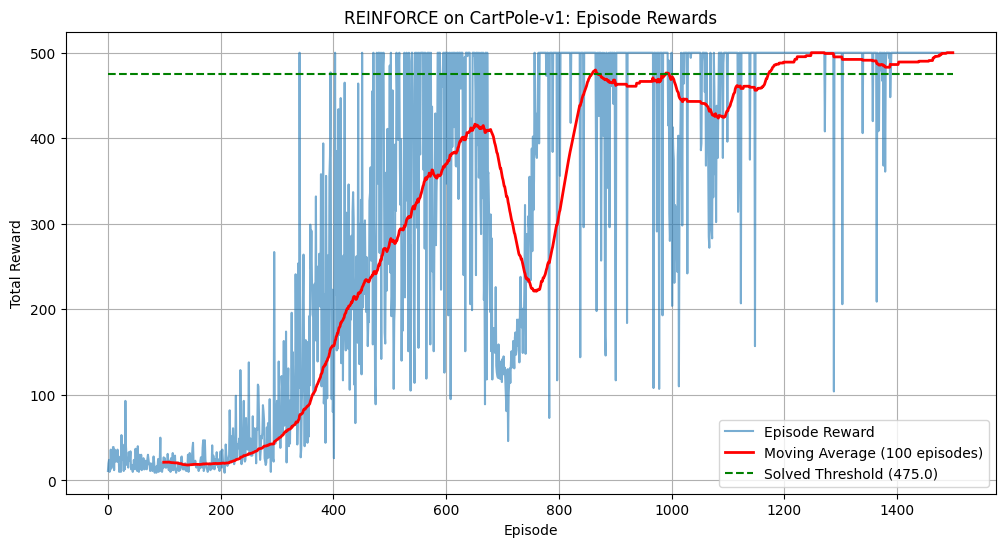

In [ ]:
def plot_rewards(rewards, window=100):
    plt.figure(figsize=(12, 6))
    plt.plot(rewards, label='Episode Reward', alpha=0.6)
    if len(rewards) >= window:
        # Use numpy convolve for moving average
        moving_avg = np.convolve(np.array(rewards), np.ones(window)/window, mode='valid')
        plt.plot(np.arange(window-1, len(rewards)), moving_avg, label=f'Moving Average ({window} episodes)', color='red', linewidth=2)
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('DQN on CartPole-v1: Episode Rewards')
    # Get reward threshold from Gymnasium spec
    reward_threshold = gym.spec("CartPole-v1").reward_threshold
    # Check if threshold is meaningful relative to plot limits before drawing
    if reward_threshold is not None and plt.ylim()[1] > reward_threshold * 0.8 :
        plt.hlines(reward_threshold, 0, len(rewards), colors='g', linestyles='dashed', label=f'Solved Threshold ({reward_threshold})')
    plt.legend()
    plt.grid(True)
    plt.show()

# --- Execution Logic ---
# Define device (should be defined globally or re-defined here)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Set seed for reproducibility
torch.manual_seed(42)

print("Training DQN Agent on CartPole-v1:")
save_file_path = "best_dqn_cartpole.pth"

# Call the training function
trained_agent_reinforce, rewards_history_reinforce = train_agent_cartpole(
    episodes=1500,
    hidden_size=64,
    lr=2e-3,
    gamma=0.99,
    print_every=50,
    save_path=save_file_path
)

# Plot the results
plot_rewards(rewards_history_reinforce)

### Analyzing DQN Performance

Alright! So, we ran our code using DQN for 1500 episodes. Let's check out the plot showing how it did!

*   **Raw Rewards (Blue Line):** Shows the reward for each episode.
*   **Moving Average (Red Line):** Smooths out the noise and shows the learning trend.
*   **Success:** The agent learns to balance the pole using Q-learning with experience replay.



<!-- Code Cell Output: A window should pop up showing the CartPole environment being controlled by the trained agent for a few episodes. -->

#### Observing Agent Behavior

You might notice interesting variations in the agent's behavior during rendering, even if it achieves the maximum reward:
*   Sometimes the cart might move rapidly back and forth (jittery).
*   Other times, it might stay relatively still with only small adjustments.

This highlights that the agent learns purely based on the reward signal. The CartPole reward is simple: +1 for every step the pole is balanced. It doesn't penalize jerky movements or reward smooth control.

Therefore, the agent finds *any* strategy that maximizes survival time, regardless of aesthetics or efficiency. If rapid adjustments keep the pole up for 500 steps, that's considered optimal by the agent according to the given reward function. To encourage smoother control, the reward function itself would need to be modified (e.g., adding penalties for large actions or high velocities).

---

### DQN Recap and Next Steps

Okay, so DQN got the job done on CartPole! It learned to balance the pole using Q-learning with experience replay.

**Advantages of DQN:**
*   **Stable Learning:** Experience replay and target network reduce variance.
*   **Off-Policy:** Can learn from past experiences, more sample-efficient.
*   **Handles Discrete Actions:** Well-suited for environments with discrete action spaces.

**Disadvantages of DQN:**
*   **Hyperparameter Sensitive:** Requires tuning of buffer size, batch size, epsilon decay, etc.
*   **Struggles with Continuous Actions:** Needs modifications for continuous action spaces.

---

### Homework: Advanced DQN Experiments

**Objective:** Extend your understanding of DQN by testing it on different environments and optimizing hyperparameters.

**Tasks:**

1. **Test on Another Gym Environment:**
   - Choose a different Gymnasium environment (e.g., `MountainCar-v0`, `Acrobot-v1`, `LunarLander-v2`).
   - Adapt the DQN agent if needed (e.g., different state/action sizes).
   - Train the agent and evaluate its performance.
   - Compare results with CartPole.

2. **Hyperparameter Optimization:**
   - Experiment with different hyperparameters: At least 5 combinations (if it takes too long).
     - Learning rate (lr): Try 1e-4, 5e-4, 1e-3, 5e-3
     - Hidden layer size: Try 32, 64, 128, 256
     - Batch size: Try 32, 64, 128
     - Buffer size: Try 5000, 10000, 20000
     - Epsilon decay: Try 0.99, 0.995, 0.999
     - Gamma: Try 0.9, 0.95, 0.99, 0.999
   - Use a systematic approach (e.g., grid search or random search) to find better combinations.
   - Compare the best configuration with the default one.

3. **Analysis and Reporting:**
   - Plot learning curves for different hyperparameter settings.
   - Explain the impact of each hyperparameter on performance:
     - **Learning Rate:** Controls step size in gradient updates. Too high → unstable, too low → slow convergence.
     - **Hidden Size:** Network capacity. Larger → can learn complex functions, but risk overfitting.
     - **Batch Size:** Number of samples per update. Larger → more stable gradients, but slower updates.
     - **Buffer Size:** Experience memory. Larger → more diverse samples, but older experiences.
     - **Epsilon Decay:** Exploration rate reduction. Faster decay → exploit sooner, slower → explore longer.
     - **Gamma:** Discount factor. Higher → values future rewards more, lower → focuses on immediate rewards.
   - Discuss which hyperparameters had the biggest impact and why.

**Submission:** Create a notebook or report showing your experiments, results, and explanations.
